# Project 2:  Lucid Titanic Sleuthing

## Part 1: Developing an understanding of the data

#### Based on the description of the data you read in the readme describe in your own words this data.

The data describes passengers on the Titanic and Lusitania.  It records whether or not the passenger survived, and various simple data on each passenger.

#### Based on our conceptual understanding of the columns in this data set.  What are the reasonable range of the values for the Sex, Age, SibSp, Parch columns.

### Titanic:

The 'Sex' column should include Male and Female entries, and possibly an explicit Unknown string.  Given the age of the data, it is unlikely to contain more nuanced or 'other' tags.  Age should contain values between 0 for infants and 80-100 for the oldest passengers.  SibSp is likely to be between 0 and 10-12 for the largest families.  Parch could similarly be up to 10-12 for a large family.  All columns may be empty if the value is unknown.

### Lusitania:

The 'Sex' and 'Age' columns are the only ones among the columns specified that also exists in the Lusitania data set, and it has the same reasonable entries as for the Titanic data set.

### Open the data in sublime text is there anything that jumps out to you?

### Titanic:

The frequency of missing data is different for different columns.  The passenger class, survival, and name columns exist (at first glance) for all passengers.  Other columns may be missing.  Moreover, the data set is divided by passenger class, and there are generally more missing values for passengers in lower class cabins than in upper class cabins.  Survival probability also appears to be generically lower for lower class cabins.

### Lusitania:

The Lusitania data set has significantly more entries than the Titanic data, and also more empty entries.  It includes data for both passengers and crew, whereas the Titanic has data only for passengers.  The data set also contains more strings variables -- for instance, the 'Fate' field is expressed as a string whereas the 'Survival' field in the Titanic data set is expressed as a boolean.

## Part 2: reading the data in

#### Now read the data into a Pandas DataFrame

In [ ]:
import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [159]:
titanic = pd.read_csv(open("assets/titanic.csv"))
lusitania = pd.read_csv(open("assets/lusitania.csv"))

#### Check that the age column doesn't have any unreasonable values 

Min age :  0.17
Max age :  80.0
Mean age :  29.8811376673


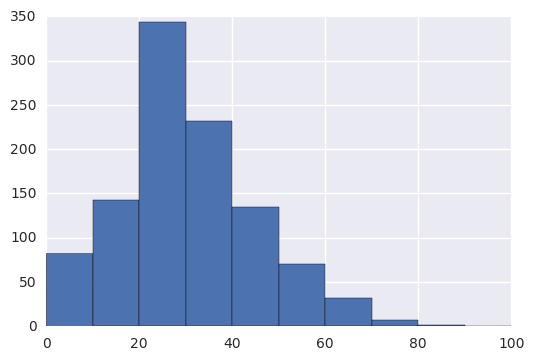

In [161]:
# Titanic

print "Min age : ", titanic[titanic.age.isnull() == False].age.min()
print "Max age : ", titanic[titanic.age.isnull() == False].age.max()
print "Mean age : ", titanic[titanic.age.isnull() == False].age.mean()
plt.hist(titanic[titanic.age.isnull() == False].age, bins = 10, range=[0,100])
plt.show()

# The non-null values seem reasonable

Min age :  1.0
Max age :  76.0
Mean age :  33.2852226721


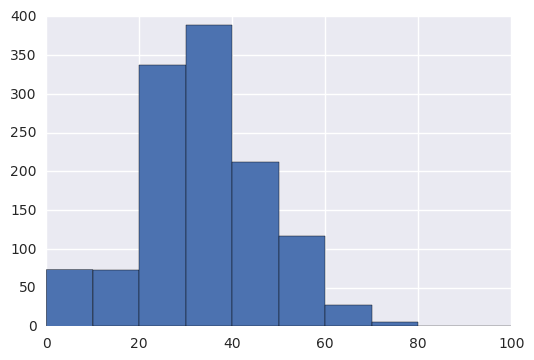

In [162]:
# Lusitania

def lusitania_clean_age(val):
    try:
        return float(val)
    except:
        return np.nan

# The Lusitania data set has strings in the 'Age' column which must be cleaned to compute statistics.
# For initial statistics, I simply remove these values.
lusitania["Cleaned_Age"] = lusitania.Age.apply(lusitania_clean_age)

print "Min age : ", lusitania[lusitania.Cleaned_Age.isnull() == False].Cleaned_Age.min()
print "Max age : ", lusitania[lusitania.Cleaned_Age.isnull() == False].Cleaned_Age.max()
print "Mean age : ", lusitania[lusitania.Cleaned_Age.isnull() == False].Cleaned_Age.mean()
plt.hist(lusitania[lusitania.Cleaned_Age.isnull() == False].Cleaned_Age, bins = 10, range=[0,100])
plt.show()


# The non-null values seem reasonable.  There is a stronger preference for ages in the range 20 - 40 years
# of age, probably because of the inclusion of crew in the data set.

#### Check for missing values.  How do you know that a value is missing?

A value is missing when a 'NaN' is present.  The 'isnull()' method of the series object associated with a column can be used to produce a list of boolean values which are True if the values is NaN and False otherwise.

In [163]:
# Titanic
print "There are {} null values in the age column out of {} total values.".format( \
                titanic[titanic.age.isnull()].age.size, titanic.age.size)
print "This represents {0:.2f}% of the total values.".format( \
                100. * titanic[titanic.age.isnull()].age.size / titanic.age.size)

There are 263 null values in the age column out of 1309 total values.
This represents 20.09% of the total values.


In [164]:
# Lusitania
print "There are {} null values in the age column out of {} total values.".format( \
                lusitania[lusitania.Age.isnull()].Age.size, lusitania.Age.size)
print "This represents {0:.2f}% of the total values.".format( \
                100. * lusitania[lusitania.Age.isnull()].Age.size / lusitania.Age.size)
print "There are also {} entries but require a non-trivial converstion to numeric values.".format( \
                lusitania[~(lusitania.Age.isnull())].Age.size
                - lusitania[~(lusitania.Cleaned_Age.isnull())].Cleaned_Age.size)

There are 653 null values in the age column out of 1961 total values.
This represents 33.30% of the total values.
There are also 73 entries but require a non-trivial converstion to numeric values.


#### Does it makes sense to guess at the value?

It makes sense to guess at the age values if there are other data which may be able to predict it.

Titanic:

In the case of the Titanic only around 20% of the age data is missing and there are multiple other columns which may be correlated with age, so imputing data is reasonable.  This does create a redundancy between the age column and any other column which is used for imputation.

Lusitania:

For the Lusitania 33.3% of the age data is missing, which makes an imputation for the Lusitania still possible.  However, the resulting imputation will probably be less reliable than for the Titanic data set.

## Part 3: data imputation

#### Well let’s say that it does... You likely noticed that Age has some missing values. How many are missing?

### Titanic:

There are 263 null values in the age column out of 1309 total values.  This represents 20.09% of the total values.

### Lusitania:

There are 653 null values in the age column out of 1961 total values.  This represents 33.30% of the total values.
There are also 73 entries but require a non-trivial converstion to numeric values.

#### For the Age of the passangers ... how would you guess at the missing values using the other data present in the CSV.

### Titanic:

As a first pass, the imputed age could be set to the average age of all passengers.  While not precisely a normal distribution, it is roughly symmetric except for the high age tail.  Beyond this, it might be possible to better imputate by splitting by various variables, such as passenger class, which might imply a different age distribution, or number of siblings, which might allow selection of children.  Beyond this, it might be possible to select family groups -- for instance, matching spousal last names (particularly when the wife is listed partially using her husband's first name as part of her listing), or using a presumably lower age distribution for unmarried but possibly adult passengers (particularly female passengers listed under 'Miss').

Here I consider imputation through grouping by passenger class, number of siblings and spouses, and number of parents and children.  Each passenger class is used, and the other two are split into the classes [0, 1, 2, >2].  For each of these sub-groups, the empty ages are assigned the the mean of the non-null ages for that sub-group.

In [165]:
titanic.age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: age, dtype: float64

In [251]:
for i in range(1,4,1):
    for j in range(0,3,1):
        for k in range(0,3,1):
            subset = (titanic.pclass == i) & (titanic.sibsp == j) & (titanic.parch == k)
            titanic.age.loc[(titanic.age.isnull()) & (subset)] = titanic[subset].age.mean()
            
        
        subset = (titanic.pclass == i) & (titanic.sibsp == j) & (titanic.parch > 2)
        titanic.age.loc[(titanic.age.isnull()) & (subset)] = titanic[subset].age.mean()
        
        subset = (titanic.pclass == i) & (titanic.sibsp > 2) & (titanic.parch == j)
        titanic.age.loc[(titanic.age.isnull()) & (subset)] = titanic[subset].age.mean()
    
    subset = (titanic.pclass == i) & (titanic.sibsp > 2) & (titanic.parch > 2)
    titanic.age.loc[(titanic.age.isnull()) & (subset)] = titanic[subset].age.mean()

print("There are {} missing values remaining for age.".format(titanic[titanic.age.isnull()].size))
titanic.age.describe()

There are 0 missing values remaining for age.


In [288]:
# Add a dummy variable for summing total number of passengers
titanic["dummy"] = 1

### Lusitania:

For the Lusitania, first the ages listed as strings should be converted.  The predominant strings either have the form of "##-months" for infants or "## ?" for presumably uncertain ages.  There are also several entries that read simply "Infant".  Our approach for cleaning will be to replace try a replacement of any entry with the "-months" string with fractional values from the first two characters, then replace any remaining values with a "?" string with an age using the first two characters.  The remaining entries are set to 1 for the string "Infant" and NaN for all other values.  5 entries are set to NaN in this manner; while this represents a loss of data, it is less then one percent of the overall data set and further cleaning would be better performed by editing the original input file.

In [167]:


def lusitania_cleaner_age(val):
    try:
        return float(val)
    except Exception:
        pass

    if re.search("-months", val):
        try:
            return float(val[0:2]) / 12
        except Exception:
            return np.nan

    elif re.search("\?",val):
        try:
            return float(val[0:2])
        except Exception:
            return np.nan
    elif val == "Infant":
        return 1
    else:
        return np.nan

lusitania["Cleaned_Age"] = lusitania.Age.apply(lusitania_cleaner_age)
print "{} entries replaced by NaN.".format( \
                lusitania[~(lusitania.Age.isnull())].Age.size
                - lusitania[~(lusitania.Cleaned_Age.isnull())].Cleaned_Age.size)

5 entries replaced by NaN.


Beyond this, we can use several classification variables to impute age.  The data set provides information on whether each passenger is an Adult, Minor, or Infant in the "Adult/Minor" column, as well as whether they are Passenger or Crew in the "Passenger/Crew" entry and passenger class or crew department in the "Department/Class" column.  

Three presumed German spies are listed as stowaways in the table.  All three died, and no age data is provided for any of them.  Since this grouping is categorically different from all other individuals on the Lusitania, it will be removed for further analysis.  The same is true of the four steward's boys,   The single entry with the "Fate" listing of "Not on board" is also removed.  The entries for "Passenger/Crew" of "Third (Distressed British Seaman)" are replaced with "Third".  The entrie with "Adult/Minor" of "Minor?" are set to "Minor".

For each of the remaining entries, I break up the data set into categories based on the value in the ["Sex","Adult/Minor", "Passenger/Crew","Department/Class"], and fill values with the mean of the non-null entries for that group.

In [168]:
lusitania = lusitania[(lusitania.Fate != "Not on board")]
lusitania = lusitania[(lusitania["Department/Class"] != "Stowaway")]
lusitania["Department/Class"].loc[(lusitania["Department/Class"] == "Third (Distressed British Seaman)")] = "Third"
lusitania["Adult/Minor"].loc[(lusitania["Adult/Minor"] == "Minor?")] = "Minor"

for sex in set(lusitania["Sex"]):
    for am in set(lusitania["Adult/Minor"]):
        for dc in set(lusitania["Department/Class"]):
            for pc in set(lusitania["Passenger/Crew"]):
                subset = (sex == lusitania["Sex"]) & (am == lusitania["Adult/Minor"]) & \
                         (dc == lusitania["Department/Class"]) & (pc == lusitania["Passenger/Crew"])
                lusitania.Cleaned_Age.loc[(subset) & (lusitania.Cleaned_Age.isnull())] = \
                        lusitania.Cleaned_Age[(subset)].mean()

Finally, the survival variable is most useful as a class variable.  I map any entry of "Saved" in the "Fate" column to a "1" in a new "Survived" column, and any other entry to "0".  I also add a dummy "1" to every row.

In [169]:
lusitania["Survived"] = 0
lusitania.Survived.loc[(lusitania.Fate == "Saved")] = 1
lusitania["Dummy"] = 1

## Part 4: Group Statistics

#### Are there any groups that were especially adversely affected in the Titanic wreck? (justify your response numerically)

Below I examine survival rates with grouping by age, gender, and passenger class.  For this purpose age is masked into a classification variable for adults vs. children, then make a smaller data frame with only these values.

In [283]:
titanic["adult_child"] = "Adult"
titanic.adult_child.loc[titanic.age < 18] = "Child"

titanic_melted = pd.melt(titanic,["pclass","sex","adult_child"],'survived', value_name = "survived")
titanic_survival = pd.pivot_table(titanic_melted, index = ['pclass'], columns=['sex','adult_child'], aggfunc=np.mean)
titanic_survival

survived                              
sex            female                male          
adult_child     Adult     Child     Adult     Child
pclass                                             
1            0.970588  0.875000  0.319767  0.857143
2            0.863636  1.000000  0.089744  0.733333
3            0.500000  0.464286  0.137441  0.239437

(0, 1.2)

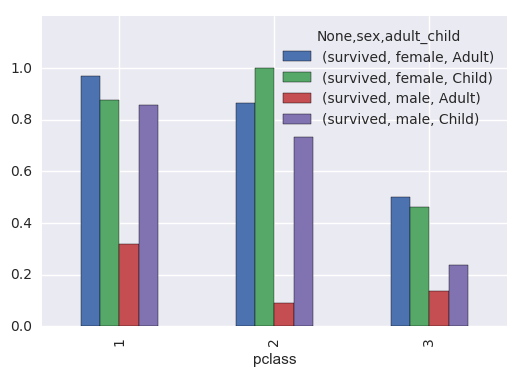

In [284]:
axes = titanic_survival.plot.bar()
axes.set_ylim([0,1.2])

In [294]:
titanic_survival_melted = pd.melt(titanic,['pclass','sex','adult_child'],'survived',value_name="survived")
titanic_totals_survival = list(pd.pivot_table(titanic_survival_melted, index = ['pclass','sex','adult_child'],
                                              aggfunc=np.sum)["survived"])

titanic_melted_dummy = pd.melt(titanic,["pclass","sex","adult_child"],'dummy', value_name = "dummy")
titanic_totals_aboard = list(pd.pivot_table(titanic_melted_dummy, index = ['pclass','sex','adult_child'],
                                     aggfunc=np.sum)['dummy'])

titanic_survival_rate = titanic.survived.mean()
print("The overall survival rate for the Titanic is {0:.2f}%".format(100. * titanic_survival_rate))

titanic_predicted_survival = [val * titanic_survival_rate for val in titanic_totals_aboard]

stats.chisquare(titanic_totals_survival,titanic_predicted_survival)

The overall survival rate for the Titanic is 38.20%
[136, 8, 172, 7, 88, 18, 156, 15, 160, 56, 422, 71]
[132, 7, 55, 6, 76, 18, 14, 11, 80, 26, 58, 17]


Power_divergenceResult(statistic=322.17130003765647, pvalue=1.8472104685824147e-62)

#### Are there any groups that outperformed the survival of the latter group? (justify your response numerically)


## Part 5:  Comparative Statistics:  Lusitania

#### Are there any groups that were especially adversely affected in the Lusitania wreck? (justify your response numerically)

In [249]:
lusitania["Adult/Minor"].loc[lusitania["Adult/Minor"] == "Infant"] = "Minor"

lusitania_melted = pd.melt(lusitania,["Passenger/Crew", "Department/Class","Sex","Adult/Minor"],
                           'Survived', value_name = "survived")
lusitania_survival = pd.pivot_table(lusitania_melted, index = ['Department/Class'],
                                    columns=["Passenger/Crew","Sex","Adult/Minor"],aggfunc=np.mean)

lusitania_survival

survived                                                \
Passenger/Crew       Crew                 Passenger                       
Sex                Female      Male          Female                Male   
Adult/Minor         Adult     Adult Minor     Adult     Minor     Adult   
Department/Class                                                          
Band                  NaN  0.600000   NaN       NaN       NaN       NaN   
Deck                  NaN  0.544118   0.0       NaN       NaN       NaN   
Engineering           NaN  0.360129   0.0       NaN       NaN       NaN   
Saloon                NaN       NaN   NaN  0.390244  0.250000  0.404255   
Second                NaN       NaN   NaN  0.370968  0.347826  0.389961   
Third                 NaN       NaN   NaN  0.375000  0.333333  0.355932   
Victualling          0.36  0.457249   0.5       NaN       NaN       NaN   

                            
Passenger/Crew              
Sex                         
Adult/Minor          Minor  
Department/Class            
Band                   NaN  
Deck                   NaN  
Engineering            NaN  
Saloon            0.166667  
Second            0.375000  
Third             0.344828  
Victualling            NaN

survived                
Passenger/Crew       Crew                
Sex                Female      Male      
Adult/Minor         Adult     Adult Minor
Department/Class                         
Band                  NaN  0.600000   NaN
Deck                  NaN  0.544118   0.0
Engineering           NaN  0.360129   0.0
Victualling          0.36  0.457249   0.5

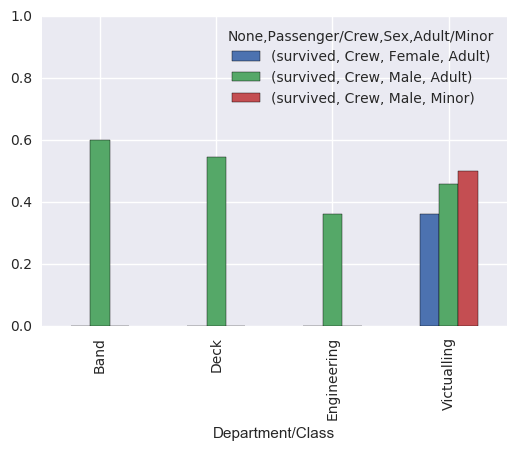

In [257]:
lusitania_crew = lusitania[lusitania["Passenger/Crew"] == "Crew"]
lusitania_crew_melted = pd.melt(lusitania_crew,["Passenger/Crew","Department/Class","Sex","Adult/Minor"],
                                                'Survived', value_name = "survived")
lusitania_crew_survival = pd.pivot_table(lusitania_crew_melted, index = ['Department/Class'],
                                         columns=["Passenger/Crew","Sex","Adult/Minor"],aggfunc=np.mean)

axes = lusitania_crew_survival.plot.bar()
axes.set_ylim([0,1])
lusitania_crew_survival

survived                              
Passenger/Crew   Passenger                              
Sex                 Female                Male          
Adult/Minor          Adult     Minor     Adult     Minor
Department/Class                                        
Saloon            0.390244  0.250000  0.404255  0.166667
Second            0.370968  0.347826  0.389961  0.375000
Third             0.375000  0.333333  0.355932  0.344828

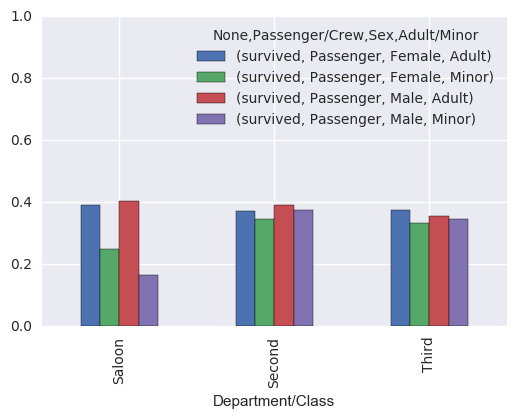

In [260]:
lusitania_passengers = lusitania[lusitania["Passenger/Crew"] == "Passenger"]
lusitania_passengers_melted = pd.melt(lusitania_passengers,["Passenger/Crew", "Department/Class","Sex","Adult/Minor"],
                                                            'Survived', value_name = "survived")
lusitania_passengers_survival = pd.pivot_table(lusitania_passengers_melted, index = ['Department/Class'],
                                               columns=["Passenger/Crew","Sex","Adult/Minor"],aggfunc=np.mean)

axes = lusitania_passengers_survival.plot.bar()
axes.set_ylim([0,1])
lusitania_passengers_survival

In [279]:
lusitania_totals_survival = list(pd.pivot_table(lusitania_melted,
                                           index = ['Department/Class',"Passenger/Crew","Sex","Adult/Minor"],
                                           aggfunc=np.sum)['survived'])

lusitania_totals_melted = pd.melt(lusitania,["Passenger/Crew", "Department/Class","Sex","Adult/Minor"],
                                  'Dummy', value_name = "dummy")
lusitania_totals_aboard = list(pd.pivot_table(lusitania_totals_melted,
                                           index = ['Department/Class',"Passenger/Crew","Sex","Adult/Minor"],
                                           aggfunc=np.sum)['dummy'])

lusitania_survival_rate = lusitania.Survived.mean()
print("The overall survival rate for the Lusitania is {0:.2f}%".format(100. * lusitania_survival_rate))

lusitania_predicted_survival = [val * lusitania_survival_rate for val in lusitania_totals_aboard]

stats.chisquare(lusitania_totals_survival,lusitania_predicted_survival)

The overall survival rate for the Lusitania is 38.99%


Power_divergenceResult(statistic=13.652507847888861, pvalue=0.80355840256466793)

#### Are there any groups that outperformed the survival of the latter group? (justify your response numerically)



### What does the group-wise survival rate imply about circumstances during these two accidents?